In [2]:
import cv2
import matplotlib.pyplot as plt

In [21]:
img = 'C:/Users/user/Desktop/datasets/Child Skin Disease/Total_Dataset/H0/Hand eczema/H0_18288_P3_L0.jpg'

img = cv2.imread(img, cv2.COLOR_BGR2RGB) 
# print(img)

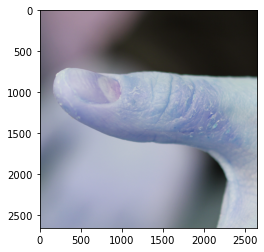

In [22]:

plt.imshow(img) 
plt.show() 

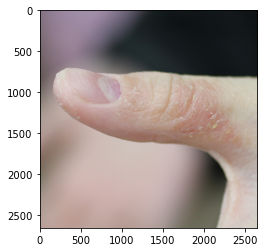

In [23]:
fix_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(fix_img)


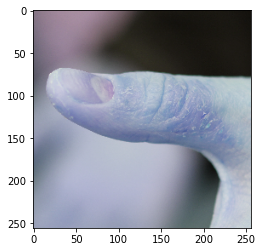

In [20]:
img = cv2.resize(img, (256, 256))

plt.imshow(img) 
plt.show() 

In [26]:
import time
type(time.strftime("%Y%m%d"))

str